# Forward projection of a “point by point” grain map
A quick experiment to see whether we can compute something like images to compare to the
experimental data for validation.
The idea is to pick the best grain at each point, then compute the spots coming from that voxel.
These are plotted onto pole figures in azimuth / omega space to easily compare to reduced data
frm frames. Also as sinograms, with one for each hkl ring.
Some other notebook will be set up to prepare the experimental data into such a format.

In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "0"
import sys
from matplotlib import pyplot as plt
import numpy as np
import ImageD11.sinograms.dataset
import ImageD11.sinograms.tensor_map
import ImageD11.sinograms.geometry
import time
from scipy.spatial.transform import Rotation as R

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

start_time = time.time()

In [2]:
# make a 3x3 map where there's a small amount of misorientations

In [3]:
asc = ImageD11.unitcell.Phases.from_json('pars.json')
ucell = asc.unitcells['Cr']
ucell

Cr | [ 2.885  2.885  2.885 90.    90.    90.   ] | 229

In [4]:
ucell.B

array([[ 3.46620451e-01, -1.32706021e-16, -1.32706021e-16],
       [ 0.00000000e+00,  3.46620451e-01, -2.12243813e-17],
       [ 0.00000000e+00,  0.00000000e+00,  3.46620451e-01]])

In [5]:
R0 = R.random()
R0

In [6]:
U0 = R0.as_matrix()
U0

array([[ 0.30661283,  0.90340924, -0.29973376],
       [ 0.44032791, -0.41380524, -0.79679141],
       [-0.84386012,  0.11232532, -0.5246743 ]])

In [7]:
# now make 16 random small misorientations
# do these as Euler angles with ranges
ny = 4
n_voxels = ny * ny
# generates random values in the (0, 1) interval - we can consider those directly as degrees for small rotations
random_euler = np.random.random(size=(n_voxels, 3))
random_euler

array([[0.48857548, 0.39809443, 0.09288277],
       [0.61926888, 0.6562534 , 0.80864669],
       [0.51561298, 0.38177274, 0.31530683],
       [0.98952062, 0.96554583, 0.41732071],
       [0.42612564, 0.69143012, 0.23558258],
       [0.15900578, 0.66999699, 0.00440976],
       [0.74813226, 0.91521351, 0.45377055],
       [0.11379697, 0.05716245, 0.4324729 ],
       [0.59141184, 0.38902063, 0.36412797],
       [0.73394349, 0.72790898, 0.26437575],
       [0.75625566, 0.67884594, 0.40976681],
       [0.1212092 , 0.64964052, 0.84756389],
       [0.92648098, 0.66064872, 0.88760554],
       [0.6150506 , 0.82397408, 0.61081555],
       [0.1864574 , 0.13400152, 0.93003724],
       [0.66992259, 0.94933657, 0.19401235]])

In [8]:
delta_R = R.from_euler('XYZ', angles=random_euler, degrees=True)
delta_R.as_matrix()

array([[[ 9.99974548e-01, -1.62107025e-03,  6.94800262e-03],
        [ 1.68029701e-03,  9.99962233e-01, -8.52694164e-03],
        [-6.93391744e-03,  8.53839932e-03,  9.99939506e-01]],

       [[ 9.99834818e-01, -1.41121529e-02,  1.14535321e-02],
        [ 1.42360325e-02,  9.99840255e-01, -1.08073616e-02],
        [-1.12991873e-02,  1.09686293e-02,  9.99876001e-01]],

       [[ 9.99962659e-01, -5.50299246e-03,  6.66314204e-03],
        [ 5.56285265e-03,  9.99944036e-01, -8.99882290e-03],
        [-6.61324870e-03,  9.03555296e-03,  9.99937310e-01]],

       [[ 9.99831488e-01, -7.28252181e-03,  1.68511562e-02],
        [ 7.57347371e-03,  9.99822229e-01, -1.72670822e-02],
        [-1.67224126e-02,  1.73917942e-02,  9.99708901e-01]],

       [[ 9.99918733e-01, -4.11138067e-03,  1.20674393e-02],
        [ 4.20131387e-03,  9.99963522e-01, -7.43668541e-03],
        [-1.20364241e-02,  7.48678015e-03,  9.99899531e-01]],

       [[ 9.99931627e-01, -7.69595293e-05,  1.16933870e-02],
        [ 1.09

In [9]:
R_voxels = delta_R * R0

In [10]:
U_voxels = R_voxels.as_matrix()
U_voxels

array([[[ 0.30002808,  0.90483749, -0.30207992],
        [ 0.44802203, -0.41322941, -0.79279109],
        [-0.8421754 ,  0.10252113, -0.52936755]],

       [[ 0.29068303,  0.91038621, -0.29444918],
        [ 0.45374243, -0.40209211, -0.7952608 ],
        [-0.84239016,  0.09756473, -0.5299622 ]],

       [[ 0.2985555 ,  0.90640111, -0.29883381],
        [ 0.44960266, -0.40976734, -0.79369274],
        [-0.84185632,  0.10260485, -0.52985864]],

       [[ 0.28913444,  0.90816336, -0.30272197],
        [ 0.45714276, -0.40882926, -0.7898602 ],
        [-0.84108369,  0.08998863, -0.53336693]],

       [[ 0.29459432,  0.90639261, -0.30276497],
        [ 0.44787555, -0.41082997, -0.79411978],
        [-0.84416922,  0.09834215, -0.52697926]],

       [[ 0.29669039,  0.90469278, -0.30578717],
        [ 0.44270146, -0.4140165 , -0.79536517],
        [-0.84616206,  0.10060478, -0.52334353]],

       [[ 0.28959846,  0.9083366 , -0.3017571 ],
        [ 0.45378474, -0.40788021, -0.7922835 ],
        

In [11]:
UB_voxels = U_voxels @ ucell.B
UB_voxels

array([[[ 0.10399587,  0.31363518, -0.10470708],
        [ 0.1552936 , -0.14323376, -0.27479761],
        [-0.29191522,  0.03553592, -0.18348962]],

       [[ 0.10075668,  0.31555848, -0.10206211],
        [ 0.1572764 , -0.13937335, -0.27565366],
        [-0.29198966,  0.03381793, -0.18369574]],

       [[ 0.10348544,  0.31417716, -0.10358191],
        [ 0.15584148, -0.14203374, -0.27511014],
        [-0.29180462,  0.03556494, -0.18365984]],

       [[ 0.10021991,  0.31478799, -0.10492963],
        [ 0.15845503, -0.14170858, -0.2737817 ],
        [-0.29153681,  0.0311919 , -0.18487588]],

       [[ 0.10211242,  0.31417421, -0.10494453],
        [ 0.15524283, -0.14240207, -0.27525816],
        [-0.29260632,  0.0340874 , -0.18266179]],

       [[ 0.10283896,  0.31358502, -0.10599209],
        [ 0.15344938, -0.14350658, -0.27568983],
        [-0.29329707,  0.03487167, -0.18140157]],

       [[ 0.10038075,  0.31484804, -0.10459518],
        [ 0.15729107, -0.14137962, -0.27462166],
        

In [12]:
UBI_voxels = np.linalg.inv(UB_voxels)
UBI_voxels

array([[[ 0.86558101,  1.29254356, -2.42967604],
        [ 2.61045615, -1.19216684,  0.29577346],
        [-0.87150056, -2.2872023 , -1.52722539]],

       [[ 0.83862053,  1.3090469 , -2.43029562],
        [ 2.62646422, -1.16003574,  0.28147425],
        [-0.84948589, -2.29432741, -1.52894095]],

       [[ 0.86133261,  1.29710368, -2.42875548],
        [ 2.6149672 , -1.18217879,  0.296015  ],
        [-0.86213555, -2.28980356, -1.52864219]],

       [[ 0.83415287,  1.31885687, -2.42652644],
        [ 2.62005128, -1.17947242,  0.2596172 ],
        [-0.87335289, -2.27874667, -1.53876359]],

       [[ 0.84990462,  1.29212097, -2.4354282 ],
        [ 2.61494267, -1.18524445,  0.28371711],
        [-0.87347693, -2.29103557, -1.52033518]],

       [[ 0.85595178,  1.27719372, -2.44117754],
        [ 2.61003866, -1.19443759,  0.29024479],
        [-0.88219598, -2.29462852, -1.50984609]],

       [[ 0.83549155,  1.30916898, -2.43130736],
        [ 2.62055111, -1.17673442,  0.26689513],
        

In [13]:
UBI_voxels.shape

(16, 3, 3)

In [14]:
UBI_voxels = UBI_voxels.reshape((ny,ny,3,3))

In [15]:
UBI_voxels[0,0], UBI_voxels[0,1]

(array([[ 0.86558101,  1.29254356, -2.42967604],
        [ 2.61045615, -1.19216684,  0.29577346],
        [-0.87150056, -2.2872023 , -1.52722539]]),
 array([[ 0.83862053,  1.3090469 , -2.43029562],
        [ 2.62646422, -1.16003574,  0.28147425],
        [-0.84948589, -2.29432741, -1.52894095]]))

In [16]:
tmap = ImageD11.sinograms.tensor_map.TensorMap.from_ubis(UBI_voxels)
tmap.add_map('phase_ids', np.zeros((1, ny, ny),  dtype=int))
tmap.steps[1:] = (2.0, 2.0)  # 2 um step
tmap.phases[0] = ucell
for field in tmap.maps.values():
    print(field.shape)

(1, 4, 4, 3, 3)
(1, 4, 4)


In [17]:
tmap.get_ipf_maps()

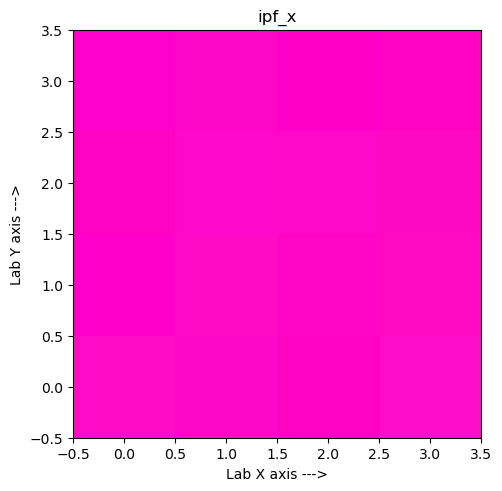

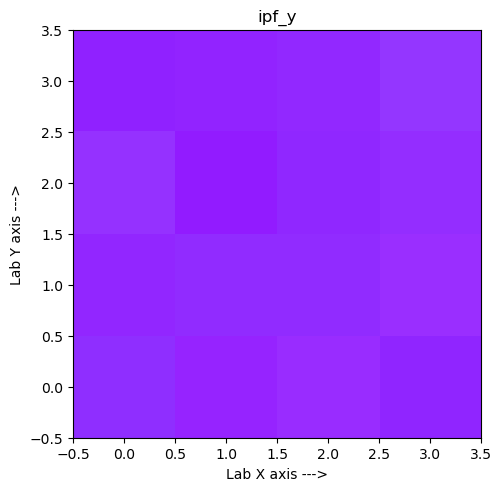

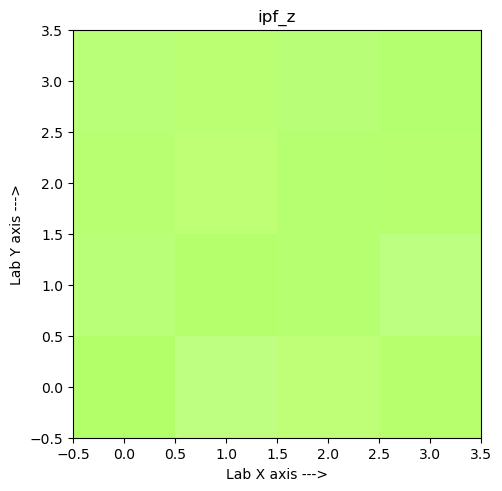

In [18]:
tmap.plot('ipf_x')
tmap.plot('ipf_y')
tmap.plot('ipf_z')

In [19]:
!rm phantom.h5
tmap.to_h5('phantom.h5')

In [20]:
end_time = time.time()
print(f'Took {end_time - start_time} seconds')

Took 1.904179334640503 seconds
